In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv
/kaggle/input/kaggle-json/kaggle.json


In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [5]:
train_df.isna().sum()

id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

In [6]:
train_data = train_df.copy()
train_data.drop('id',axis=1,inplace=True)
for col in train_data.columns[:8]:
    print(f"{col} : {train_data[col].unique()} | count {len(train_data[col].unique())}")

Brand : ['Jansport' 'Under Armour' 'Nike' 'Adidas' 'Puma' nan] | count 6
Material : ['Leather' 'Canvas' 'Nylon' nan 'Polyester'] | count 5
Size : ['Medium' 'Small' 'Large' nan] | count 4
Compartments : [ 7. 10.  2.  8.  1.  3.  5.  9.  6.  4.] | count 10
Laptop Compartment : ['Yes' 'No' nan] | count 3
Waterproof : ['No' 'Yes' nan] | count 3
Style : ['Tote' 'Messenger' nan 'Backpack'] | count 4
Color : ['Black' 'Green' 'Red' 'Blue' 'Gray' 'Pink' nan] | count 7


In [7]:
feature_dict = {}
for col in (train_data.columns[:8]):
    if col == 'Compartments':
        continue
    else:
        feature_dict[col] = {key:value for value, key in enumerate(train_data[col].unique())}
        train_data[col] = train_data[col].map(feature_dict[col])
        print(f"mapping dict {feature_dict[col]}")


mapping dict {'Jansport': 0, 'Under Armour': 1, 'Nike': 2, 'Adidas': 3, 'Puma': 4, nan: 5}
mapping dict {'Leather': 0, 'Canvas': 1, 'Nylon': 2, nan: 3, 'Polyester': 4}
mapping dict {'Medium': 0, 'Small': 1, 'Large': 2, nan: 3}
mapping dict {'Yes': 0, 'No': 1, nan: 2}
mapping dict {'No': 0, 'Yes': 1, nan: 2}
mapping dict {'Tote': 0, 'Messenger': 1, nan: 2, 'Backpack': 3}
mapping dict {'Black': 0, 'Green': 1, 'Red': 2, 'Blue': 3, 'Gray': 4, 'Pink': 5, nan: 6}


In [8]:
print(train_data.isna().sum())

Brand                     0
Material                  0
Size                      0
Compartments              0
Laptop Compartment        0
Waterproof                0
Style                     0
Color                     0
Weight Capacity (kg)    138
Price                     0
dtype: int64


In [9]:
mean_weight_capacity = train_data["Weight Capacity (kg)"].mean()
train_data.loc[train_data.isna().any(axis=1), "Weight Capacity (kg)"] = mean_weight_capacity
print(train_data.isna().sum())

Brand                   0
Material                0
Size                    0
Compartments            0
Laptop Compartment      0
Waterproof              0
Style                   0
Color                   0
Weight Capacity (kg)    0
Price                   0
dtype: int64


In [10]:
train_data

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,0,0,7.0,0,0,0,0,11.611723,112.15875
1,0,1,1,10.0,0,1,1,1,27.078537,68.88056
2,1,0,1,2.0,0,0,1,2,16.643760,39.17320
3,2,2,1,8.0,0,0,1,1,12.937220,80.60793
4,3,1,0,1.0,0,1,1,1,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...
299995,3,0,1,9.0,1,0,0,3,12.730812,129.99749
299996,0,0,2,6.0,1,1,0,3,26.633182,19.85819
299997,4,1,2,9.0,0,1,3,5,11.898250,111.41364
299998,3,2,1,1.0,1,1,0,5,6.175738,115.89080


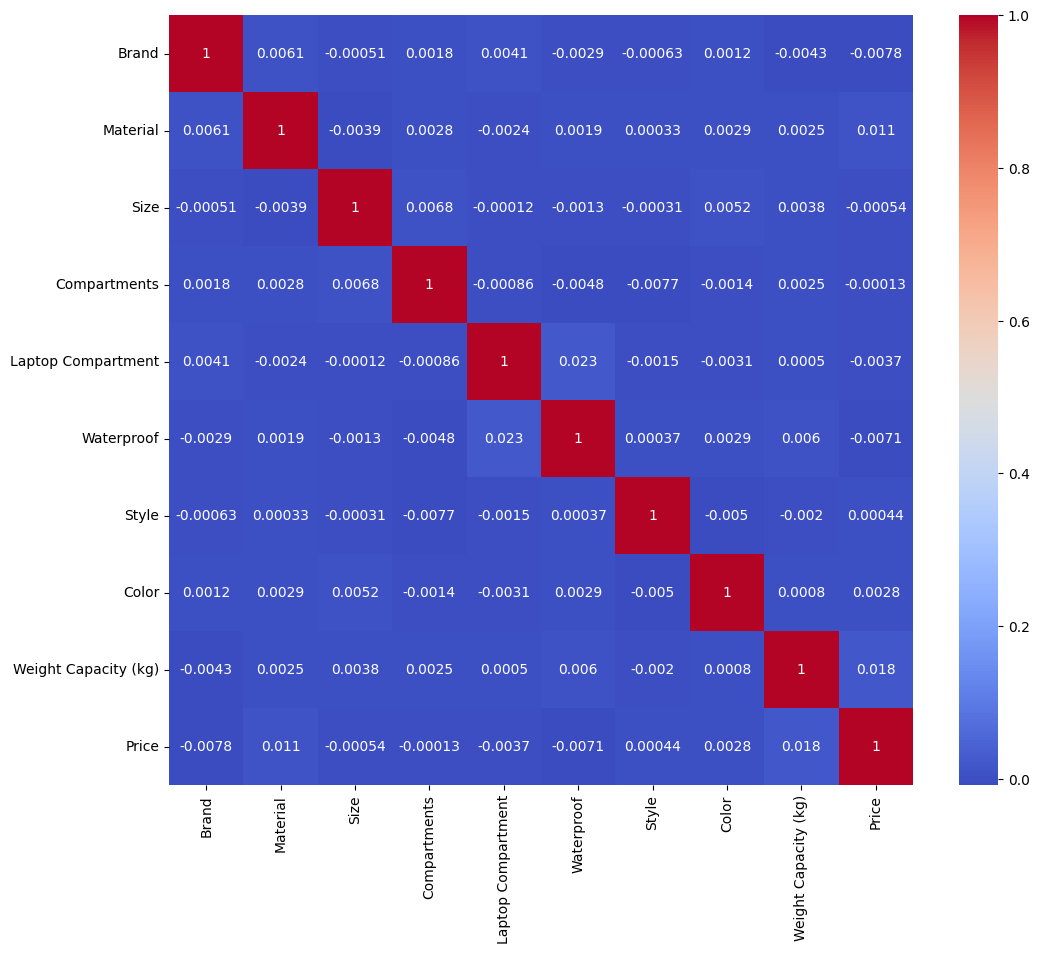

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = train_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [12]:
del train_data
train_data = train_df.copy()
train_data.drop('id',axis=1,inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 290295 non-null  object 
 1   Material              291653 non-null  object 
 2   Size                  293405 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    292556 non-null  object 
 5   Waterproof            292950 non-null  object 
 6   Style                 292030 non-null  object 
 7   Color                 290050 non-null  object 
 8   Weight Capacity (kg)  299862 non-null  float64
 9   Price                 300000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 22.9+ MB


In [13]:
class Dataset():
    def __init__(self, df, scaler=None, fit=True):
        self.df = df.copy()  # Avoid modifying the original DataFrame
        self.scaler = scaler if scaler else StandardScaler()
        self.fit = fit  
        self.df.columns 

    def transform(self):
        #if "Laptop Compartment" in self.df.columns:
            #self.df["Laptop Compartment"] = self.df["Laptop Compartment"].map({"Yes": 1, "No": 0})
            #self.df["Laptop Compartment"] = self.df["Laptop Compartment"].fillna(self.df["Laptop Compartment"].value_counts().idxmin().astype(int))


        #if "Waterproof" in self.df.columns:
            #self.df["Waterproof"] = self.df["Waterproof"].map({"Yes": 1, "No": 0})
            #self.df["Waterproof"] = self.df["Waterproof"].fillna(self.df["Waterproof"].value_counts().idxmin().astype(int))

        for col in self.df.columns[:8]:  
            #if col in ["Compartments", "Waterproof", "Laptop Compartment"]:
                #continue
            for ele in self.df[col].unique():
                if pd.isna(ele):
                    continue
                    #name = "unknown" if pd.isna(ele) else ele
                self.df[f"{col}_{ele}"] = (self.df[col].isna() | (self.df[col] == ele)).astype(int)
            self.df.drop(col, axis=1, inplace=True)

        if "Weight Capacity (kg)" in self.df.columns:
            mean_weight_capacity = self.df["Weight Capacity (kg)"].mean()
            self.df.loc[self.df.isna().any(axis=1), "Weight Capacity (kg)"] = mean_weight_capacity

    def check(self):
        """Print missing values count, number of columns, and column names."""
        print("Missing Values Per Column:\n", self.df.isna().sum())
        print("\nTotal Number of Columns:", len(self.df.columns))
        print("\nColumn Names:", list(self.df.columns))

    def dataframe(self):
        return self.df

    def normalize(self):
        if "Weight Capacity (kg)" in self.df.columns:
            if self.fit:
                self.df["Weight Capacity (kg)"] = self.scaler.fit_transform(self.df[["Weight Capacity (kg)"]])
            else:
                self.df["Weight Capacity (kg)"] = self.scaler.transform(self.df[["Weight Capacity (kg)"]])

    def create_tensors(self, is_train=True):
        if is_train:
            if "Price" not in self.df.columns:
                raise ValueError("Training data must contain a 'Price' column.")
            X = torch.empty(self.df.shape[0], len(self.df.columns) - 1)
            Y = torch.tensor(self.df["Price"].values, dtype=torch.float32).reshape(-1, 1)
            self.df["Price"] = self.df.pop("Price") 
        else:
            X = torch.empty(self.df.shape[0], len(self.df.columns))

        for i, col in enumerate(self.df.columns):
            if is_train and col == "Price":
                continue  
            data_type = torch.float32 if col == "Weight Capacity (kg)" else torch.int64  
            X[:, i] = torch.tensor(self.df[col].values, dtype=data_type)

        return (X, Y) if is_train else X


In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset = Dataset(train_data,scaler = scaler, fit= True)

In [15]:
dataset.check()

Missing Values Per Column:
 Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

Total Number of Columns: 10

Column Names: ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price']


In [16]:
dataset.transform()

In [17]:
df =  dataset.dataframe()

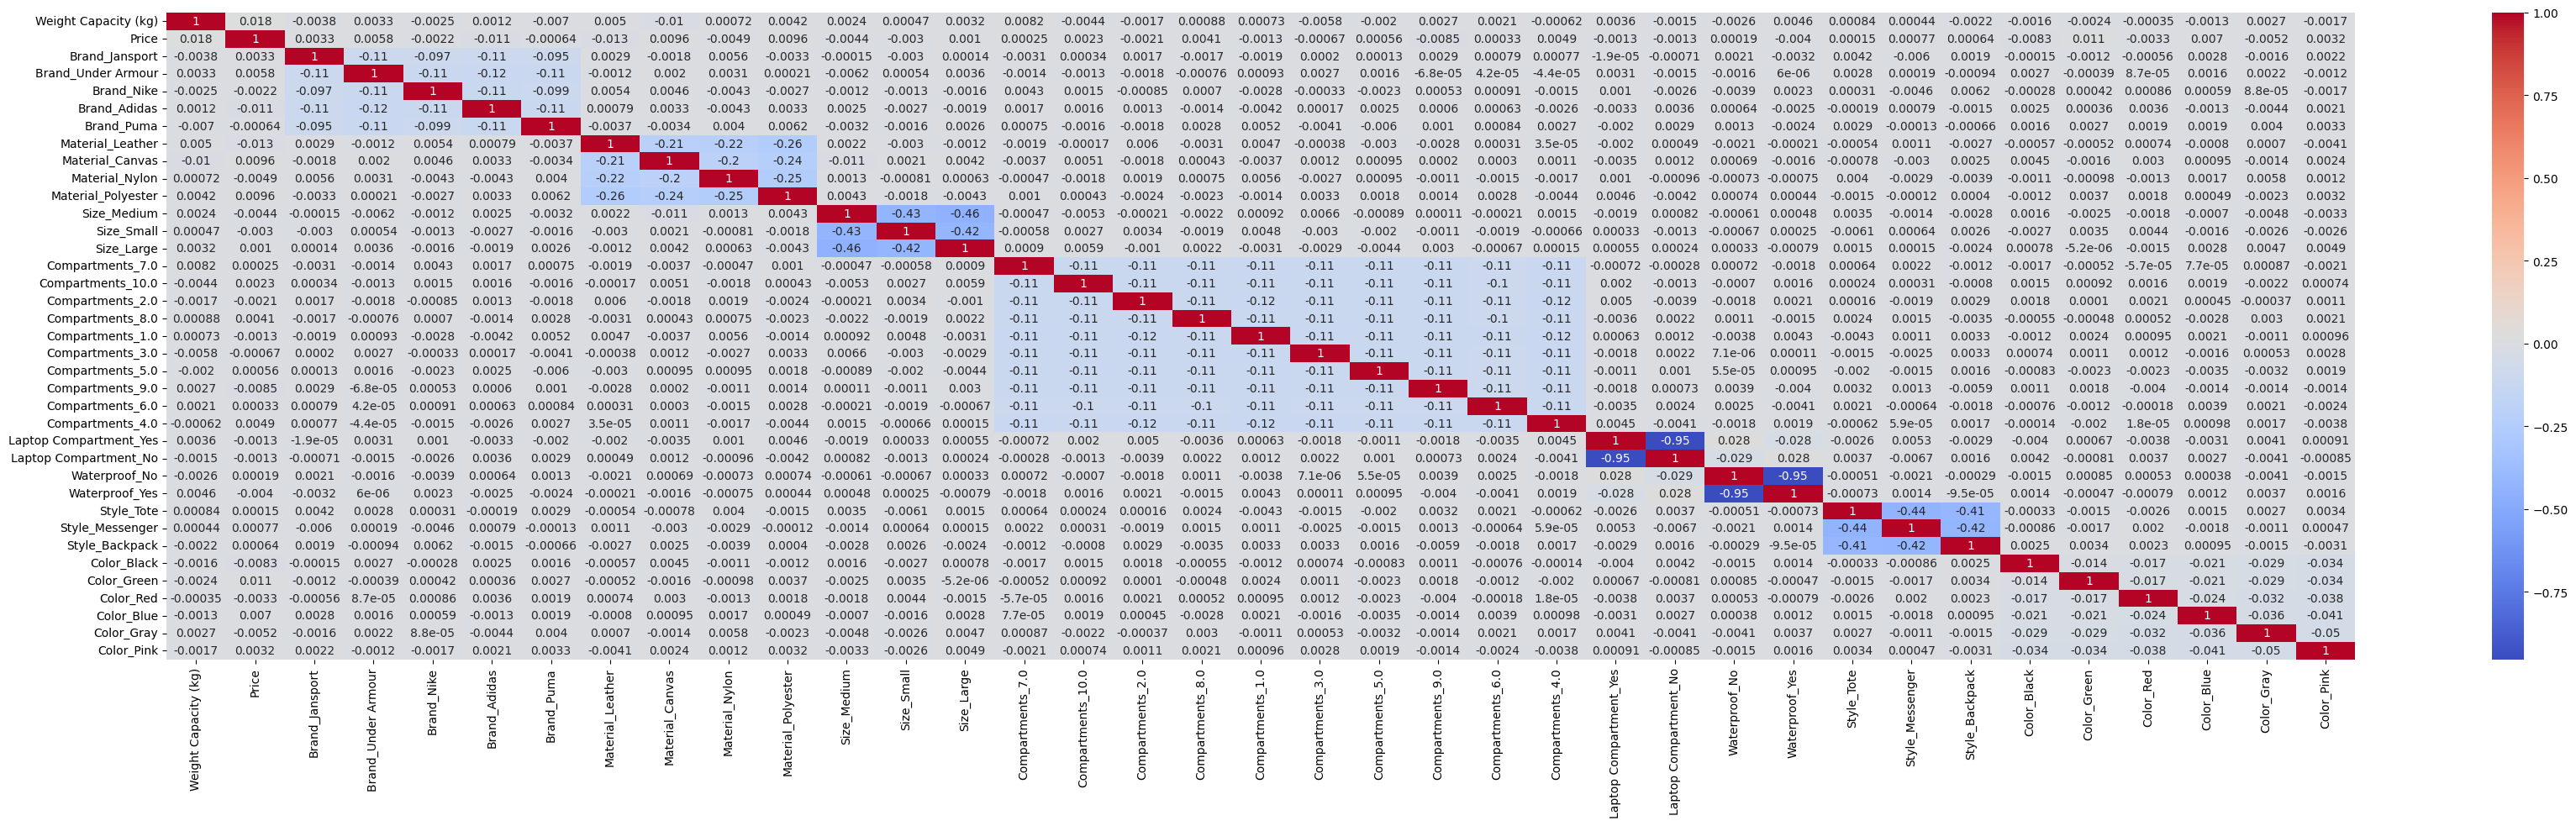

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(42, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [19]:
dataset.check()

Missing Values Per Column:
 Weight Capacity (kg)      0
Price                     0
Brand_Jansport            0
Brand_Under Armour        0
Brand_Nike                0
Brand_Adidas              0
Brand_Puma                0
Material_Leather          0
Material_Canvas           0
Material_Nylon            0
Material_Polyester        0
Size_Medium               0
Size_Small                0
Size_Large                0
Compartments_7.0          0
Compartments_10.0         0
Compartments_2.0          0
Compartments_8.0          0
Compartments_1.0          0
Compartments_3.0          0
Compartments_5.0          0
Compartments_9.0          0
Compartments_6.0          0
Compartments_4.0          0
Laptop Compartment_Yes    0
Laptop Compartment_No     0
Waterproof_No             0
Waterproof_Yes            0
Style_Tote                0
Style_Messenger           0
Style_Backpack            0
Color_Black               0
Color_Green               0
Color_Red                 0
Color_Blue          

In [20]:
dataset.normalize()

In [21]:
X_train, Y_train = dataset.create_tensors(is_train=True)

In [22]:
X_train.shape,Y_train.shape

(torch.Size([300000, 36]), torch.Size([300000, 1]))

In [23]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(X_train, Y_train)
train_size = int(0.9 * len(dataset))  # 80% for training
cv_size = len(dataset) - train_size  # Remaining 20% for testing
train_dataset, cv_dataset = random_split(dataset, [train_size, cv_size])

In [24]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
cv_loader = DataLoader(cv_dataset, batch_size=64, shuffle=False)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(43, 1,bias = True)  # 1 input feature → 1 output

    def forward(self, x):
        return self.linear(x)

In [44]:
class NeuralNetworkRegressor(nn.Module):
    def __init__(self, input_size=36, hidden_sizes=[32, 16], output_size=1):
        super(NeuralNetworkRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], hidden_sizes[3]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[3], hidden_sizes[4]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[4], output_size)  # Regression → No activation here
        )

    def forward(self, x):
        return self.model(x)

In [27]:
def train_step(model, data_loader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.0  
    for batch, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()         
    train_loss /= len(data_loader)
    return np.sqrt(train_loss)

In [28]:
def test_step(model, data_loader, loss_fn,device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch, (x,y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred,y)
            test_loss += loss.item()            
        test_loss /= len(data_loader)
    return np.sqrt(test_loss)

In [29]:
import torch
from sklearn.metrics import r2_score

def predict(X, model, device, mode, Y=None):
    X = X.to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        y_pred_np = y_pred.detach().cpu().numpy()
        if np.isnan(y_pred_np).sum() > 0:
                print("⚠️ Warning: NaN values found in model predictions!")
                y_pred_np = np.nan_to_num(y_pred_np, nan=0.0)
        if mode == "train":
            Y = Y.to(device)            
            y_true_np = Y.detach().cpu().numpy()            
            r2 = r2_score(y_true_np, y_pred_np)
    return r2 if mode=="train" else y_pred_np


In [47]:
import torch.optim.lr_scheduler as lr_scheduler
from tqdm.auto import tqdm

# Define Model, Loss, Optimizer
model = NeuralNetworkRegressor(input_size=36, hidden_sizes=[512,128,32,16, 4], output_size=1).to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 🔥 Use ReduceLROnPlateau instead of StepLR
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [48]:
epochs = 100
for epoch in tqdm(range(epochs)):
    train_loss = train_step(model, train_loader, criterion, optimizer, device)
    cv_loss = test_step(model, cv_loader, criterion, device)
    r2 = predict(X_train, model, device, mode="train", Y=Y_train)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    if epoch%10==0:
        tqdm.write(f'Epoch [{epoch+1}/{epochs}], train_Loss: {train_loss:.4f} | test_loss: {cv_loss:.4f} | r2: {r2:.4f} | LR: {current_lr:.6f}')
    
    # 🔥 Adjust LR only when validation loss stops improving
    #scheduler.step(cv_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], train_Loss: 40.0777 | test_loss: 39.4224 | r2: -0.0085 | LR: 0.001000
Epoch [11/100], train_Loss: 38.9984 | test_loss: 39.2794 | r2: 0.0055 | LR: 0.001000
Epoch [21/100], train_Loss: 38.8206 | test_loss: 39.3504 | r2: 0.0152 | LR: 0.001000
Epoch [31/100], train_Loss: 38.6579 | test_loss: 39.4783 | r2: 0.0220 | LR: 0.001000
Epoch [41/100], train_Loss: 38.5179 | test_loss: 39.5833 | r2: 0.0289 | LR: 0.001000
Epoch [51/100], train_Loss: 38.4096 | test_loss: 39.6777 | r2: 0.0338 | LR: 0.001000
Epoch [61/100], train_Loss: 38.2843 | test_loss: 39.7751 | r2: 0.0405 | LR: 0.001000
Epoch [71/100], train_Loss: 38.0327 | test_loss: 39.9575 | r2: 0.0530 | LR: 0.001000
Epoch [81/100], train_Loss: 37.7529 | test_loss: 40.3418 | r2: 0.0587 | LR: 0.001000
Epoch [91/100], train_Loss: 37.3780 | test_loss: 40.5521 | r2: 0.0822 | LR: 0.001000


In [49]:
sub = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")
sub.drop('id',axis=1,inplace=True)
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 193773 non-null  object 
 1   Material              194387 non-null  object 
 2   Size                  195619 non-null  object 
 3   Compartments          200000 non-null  float64
 4   Laptop Compartment    195038 non-null  object 
 5   Waterproof            195189 non-null  object 
 6   Style                 194847 non-null  object 
 7   Color                 193215 non-null  object 
 8   Weight Capacity (kg)  199923 non-null  float64
dtypes: float64(2), object(7)
memory usage: 13.7+ MB


In [50]:
test_dataset = Dataset(sub, scaler=scaler, fit=False) 

In [51]:
test_dataset.check()

Missing Values Per Column:
 Brand                   6227
Material                5613
Size                    4381
Compartments               0
Laptop Compartment      4962
Waterproof              4811
Style                   5153
Color                   6785
Weight Capacity (kg)      77
dtype: int64

Total Number of Columns: 9

Column Names: ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)']


In [52]:
test_dataset.transform()

In [53]:
test_dataset.check()

Missing Values Per Column:
 Weight Capacity (kg)      0
Brand_Puma                0
Brand_Nike                0
Brand_Adidas              0
Brand_Under Armour        0
Brand_Jansport            0
Material_Leather          0
Material_Canvas           0
Material_Nylon            0
Material_Polyester        0
Size_Small                0
Size_Medium               0
Size_Large                0
Compartments_2.0          0
Compartments_7.0          0
Compartments_9.0          0
Compartments_1.0          0
Compartments_8.0          0
Compartments_6.0          0
Compartments_5.0          0
Compartments_3.0          0
Compartments_10.0         0
Compartments_4.0          0
Laptop Compartment_No     0
Laptop Compartment_Yes    0
Waterproof_No             0
Waterproof_Yes            0
Style_Tote                0
Style_Backpack            0
Style_Messenger           0
Color_Green               0
Color_Blue                0
Color_Black               0
Color_Red                 0
Color_Pink          

In [54]:
test_dataset.normalize()
X_test = test_dataset.create_tensors(is_train=False)

In [55]:
X_test.shape

torch.Size([200000, 36])

In [56]:
y_pred = predict(X_test,model,device,mode="test")

In [57]:
y_pred.shape

(200000, 1)

In [58]:
output_price = pd.Series(y_pred.squeeze())
output_price

0         75.711418
1         92.893738
2         75.243561
3         88.516960
4         79.577591
            ...    
199995    82.792633
199996    65.174164
199997    74.025253
199998    88.199570
199999    90.900940
Length: 200000, dtype: float32

In [59]:
output = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")
output['Price']=output_price

In [60]:
output.to_csv("submission.csv", index=False)

In [ ]:
!ls -lh

In [ ]:
import shutil

# Move kaggle.json to the correct directory
shutil.move("/kaggle/input/kaggle-json", "/root/.kaggle/")

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle competitions submit -c Backpack-Prediction-Challenge -f submission.csv -m "My first submission"

In [ ]:
train_new_df = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv")

In [ ]:
train_new_df.info()